In [ ]:
import numpy as np # linear algebra
np.random.seed(1337)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
path_test = '/content/sample_data/testing'
path_data = '/content/sample_data/training'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)
test_image_count = len(list(path_test.glob('*/*.jpg')))
print(test_image_count)

/content/sample_data/training
879
80


In [ ]:
batch = 32
img_height = 250
img_width = 250

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

Found 879 files belonging to 4 classes.
Using 704 files for training.


In [ ]:
val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 879 files belonging to 4 classes.
Using 175 files for validation.


In [ ]:
test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 80 files belonging to 4 classes.


In [ ]:
print(train.class_names)
print(val.class_names)
print(test.class_names)

['giloma', 'meningoma', 'normal', 'pituitary']
['giloma', 'meningoma', 'normal', 'pituitary']
['giloma', 'meningoma', 'normal', 'pituitary']


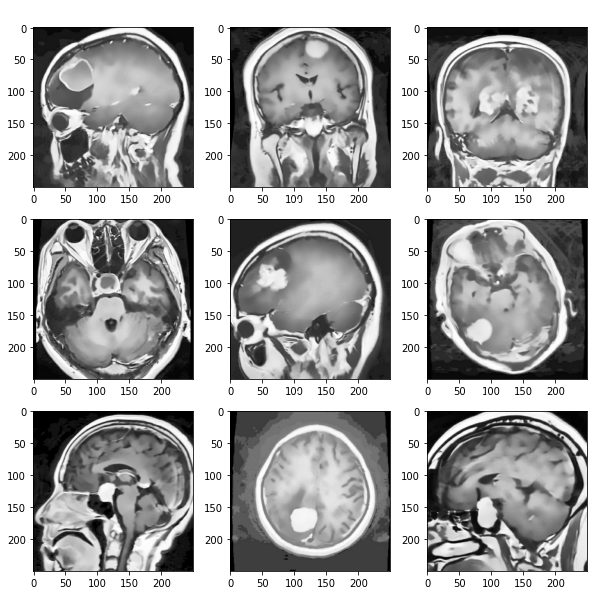

In [ ]:
classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )
        


In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
help(test.as_numpy_iterator())

Help on _NumpyIterator in module tensorflow.python.data.ops.dataset_ops object:

class _NumpyIterator(builtins.object)
 |  _NumpyIterator(dataset)
 |  
 |  Iterator over a dataset with elements converted to numpy.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  next(self)



In [ ]:
def prediction_label_comparison(model,test):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test.as_numpy_iterator().next()
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        predict.append(pred)
    predict = np.array(predict)
    print('Labels:\n', label_batch)
    print('Predictions:\n',predict)

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(classes[predict[i]],fontdict = {'fontsize': '14',
                                  'color': 'white'})
      plt.axis("off")
    return label_batch , predict

In [ ]:
def test_tumor(list_test_path,model):
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )


In [ ]:
def csv_builder(path_data,label_names):
    df = pd.DataFrame(columns = ['images','labels'])
    for name in label_names:
        BASE_DIR = str(path_data)+'/'
        train_folder_name = BASE_DIR+name+'/'
        files_in_train = sorted(os.listdir(train_folder_name))
        image_names =[i for i in files_in_train]        
        for x in image_names:
            df = df.append({'images':train_folder_name+str(x),'labels':name},ignore_index=True)
    return df

In [ ]:
def model_inputs(model2,train,val,test):
    num_classes = 4
    epochs = 15
    model2.fit(
        train,
        validation_data=val,
        epochs=epochs,
        shuffle=False,
        verbose = 0
    )
    results = model2.evaluate(test)
    return results[0],results[1] , model


In [ ]:
def cross_validation(n_splits,final_csv,test_csv,img_width,img_height,model):
    final_loss = 0
    final_acc = 0
    final_csv = final_csv.sample(frac=1)
    Y = final_csv[['labels']]
    n = len(Y)
    kf = KFold(n_splits = 5)
    idg = ImageDataGenerator(#width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.3,
#                          fill_mode='nearest',
#                          horizontal_flip = True,
                         rescale=1./255)
    
    
    
    
    print('Performing cross validation...')
    test = idg.flow_from_dataframe(test_csv,
                                       x_col = "images",
                                       y_col = "labels",
                                       class_mode = "sparse",
                                       shuffle = True,
                                      target_size = (img_width,img_height),
                                      verbose = 0)#,subset='validation')
    for train_index, val_index in kf.split(np.zeros(n),Y):
        training_data = final_csv.iloc[train_index]
        validation_data = final_csv.iloc[val_index]
        train = idg.flow_from_dataframe(training_data,
                                        x_col = "images",
                                        y_col = "labels",
                                        class_mode = "sparse",
                                        shuffle = True,
                                        subset='training',
                                       target_size = (img_width,img_height),
                                       verbose = 0)
        val = idg.flow_from_dataframe(validation_data,
                                      x_col = "images",
                                      y_col = "labels",
                                      class_mode = "sparse",
                                      shuffle = True,
                                     target_size = (img_width,img_height),
                                     verbose = 0)
        loss,acc,returned_model = model_inputs(model,train,val,test)
        final_loss += loss
        final_acc += acc
    return final_loss/n_splits , final_acc/n_splits , returned_model

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    normalization_layer,
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),  
  ]
)

/content/sample_data/training/giloma/preprocessedgiloma90.jpg


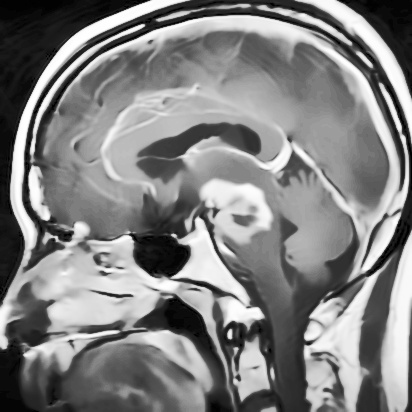

In [ ]:
tumors = []

for filename in os.listdir('/content/sample_data/training/giloma'):
      if filename.endswith("jpg"): 
        tumors.append("/content/sample_data/training/giloma/"+filename)
print(tumors[1])
img1 = PIL.Image.open(str(tumors[0]))
img1

/content/sample_data/training/normal/Normal273.jpg


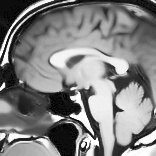

In [ ]:
not_tumors = []

for filename in os.listdir('/content/sample_data/training/normal'):
      if filename.endswith("jpg"): 
        not_tumors.append("/content/sample_data/training/normal/"+filename)
print(not_tumors[1])
img2 = PIL.Image.open(str(not_tumors[0]))
img2

In [ ]:
img_opencv = cv2.imread(str(not_tumors[0]))
print(img_opencv.shape)
img_opencv1 = cv2.imread(str(tumors[0]))
print(img_opencv1.shape)

(156, 156, 3)
(412, 412, 3)


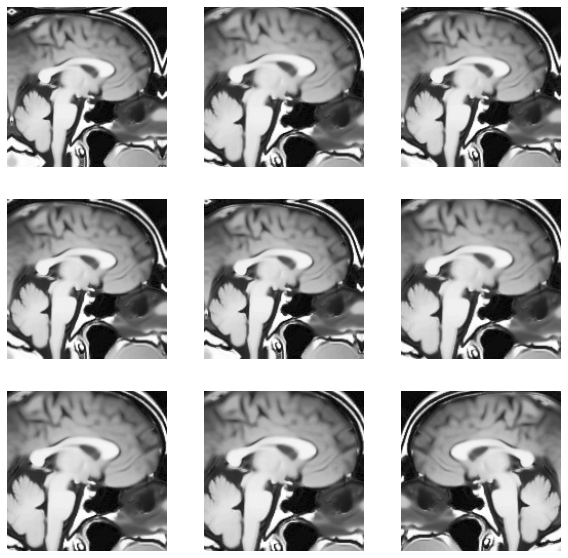

In [ ]:
plt.figure(figsize=(10, 10))
img_array = tf.keras.preprocessing.image.img_to_array(img_opencv)
img_array = tf.expand_dims(img_array,0)
for i in range(9):
  augmented_image = data_augmentation(img_array)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# New Section

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=5 ,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/5
22/22 [==============================] - 37s 2s/step - loss: 13.2319 - accuracy: 0.5057 - val_loss: 0.7364 - val_accuracy: 0.7600
Epoch 2/5
22/22 [==============================] - 33s 1s/step - loss: 0.3161 - accuracy: 0.9219 - val_loss: 0.4619 - val_accuracy: 0.8571
Epoch 3/5
22/22 [==============================] - 33s 1s/step - loss: 0.0877 - accuracy: 0.9901 - val_loss: 0.4587 - val_accuracy: 0.8743
Epoch 4/5
22/22 [==============================] - 33s 1s/step - loss: 0.0287 - accuracy: 0.9986 - val_loss: 0.3611 - val_accuracy: 0.9086
Epoch 5/5
22/22 [==============================] - 33s 1s/step - loss: 0.0124 - accuracy: 0.9986 - val_loss: 0.3682 - val_accuracy: 0.9143


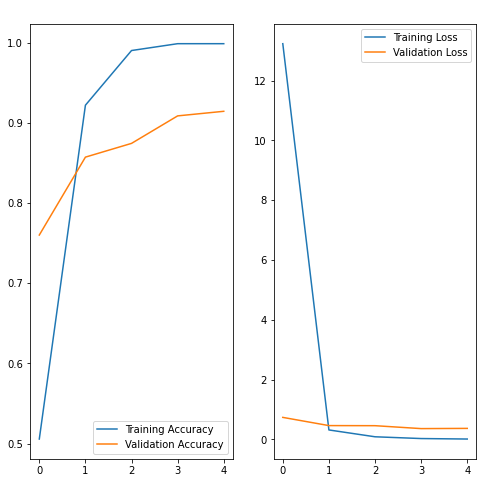

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [ ]:
model.summary()
model.save("braintumor.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 128)               62980224  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                      

In [ ]:
results = model.evaluate(test)
print("test loss, test acc:", results)

3/3 [==============================] - 1s 263ms/step - loss: 4.5455 - accuracy: 0.4500
test loss, test acc: [4.545502185821533, 0.44999998807907104]


In [ ]:
list_of_paths = ['/content/sample_data/training/giloma/preprocessedgiloma121.jpg',
                 '/content/sample_data/testing/meningoma/menin12.jpg',
                 '/content/sample_data/testing/normal/Norm7.jpg',
                 '/content/sample_data/testing/pituitary/pit1.jpg']
test_tumor(list_of_paths,model)

This image most likely belongs to giloma with a 99.63 percent confidence.
This image most likely belongs to normal with a 72.00 percent confidence.
This image most likely belongs to normal with a 99.98 percent confidence.
This image most likely belongs to pituitary with a 97.69 percent confidence.


In [ ]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[3 3 2 2 2 3 2 2 2 2 2 2 3 2 2 2 2 2 3 2 2 2 3 2 2 2 2 2 3 2 2 2 2 3 2 2 2
 3 2 2 2 3 2 2 2 2 2 2 2 2 3 3 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2
 2 2 2 3 2 3]
[3 3 2 1 1 3 0 0 0 3 1 2 3 0 2 2 2 0 3 1 1 0 0 0 1 1 0 0 3 2 3 1 2 3 0 2 2
 3 2 2 0 3 0 1 1 0 1 2 1 2 3 0 2 0 3 0 1 3 3 1 2 1 2 2 0 1 2 3 0 2 1 3 3 0
 2 1 1 3 1 3]


In [ ]:
print(len(pred_entire))
print(len(labels_entire))

80
80


In [ ]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

              precision    recall  f1-score   support

      giloma       0.00      0.00      0.00        20
   meningoma       0.00      0.00      0.00        20
      normal       0.32      1.00      0.49        20
   pituitary       0.89      0.80      0.84        20

    accuracy                           0.45        80
   macro avg       0.30      0.45      0.33        80
weighted avg       0.30      0.45      0.33        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
